In [16]:
# Import modules
import ee
import folium
import requests
import numpy as np
import io
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors


In [2]:
# Define necessary functions
def create_raster(ee_object, vis_params, name):
    raster = folium.raster_layers.TileLayer(ee_object.getMapId(vis_params)['tile_fetcher'].url_format,
                       name=name,
                       overlay=True,
                       control=True,
                       attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>')
    return raster

In [4]:
# Initialize the library.
ee.Initialize()


## Example 1: Global elevation map

In [34]:
# Get image with elevation data from the Shuttle Radar Topography Mission (SRTM)
srtm = ee.Image("USGS/SRTMGL1_003")

In [31]:
# Create a colormap. 
# You can also obtain a colormap from Matplotlib
cmap = ['white', 'blue', 'green', 'yellow', 'orange', 'red']

# Define visualization parameters
vis_params = {'min': 0,'max': 2500,
              'palette': cmap
}

In [33]:
# Create figure
m = folium.Map(location=[38, -98], zoom_start=2)
elv = folium.TileLayer(srtm.getMapId(vis_params)['tile_fetcher'].url_format,
                       name='Elevation map',
                       overlay=True,
                       control=True,
                       attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>')
elv.add_to(m)
m.add_child(folium.LayerControl())
m

## Example 2: State-level climate

In [4]:
# Read US states
US_states = ee.FeatureCollection("TIGER/2018/States")

# Select Kansas
kansas = US_states.filter(ee.Filter.eq('NAME','Kansas'))


In [5]:
# Select dataset
worldclim = ee.Image('WORLDCLIM/V1/BIO').clip(kansas)

# Select band
annual_temperature = worldclim.select('bio01').multiply(0.1)
annual_precip = worldclim.select('bio12')


In [6]:
# Find and print min and max temperature to adjust the range of the colormap
#.reduce(ee.Reducer.minMax()).getInfo()

annual_temperature.reduceRegion(**{'reducer': ee.Reducer.minMax(),
                                   'geometry': kansas.geometry(),
                                   'scale': 250}).getInfo()


{'bio01_max': 14.5, 'bio01_min': 9.9}

In [7]:
# Find and print min and max precipitation to adjust the range of the colormap
annual_precip.reduceRegion(**{'reducer': ee.Reducer.minMax(),
                              'geometry': kansas.geometry(),
                              'scale': 250}).getInfo()

{'bio12_max': 1096, 'bio12_min': 385}

In [8]:
# Set colormaps for each variable
# https://colorbrewer2.org

cmap_temp = ['#762a83','#af8dc3','#e7d4e8','#f7f7f7','#d9f0d3','#7fbf7b','#1b7837']
vis_params_temp = {'bands':["bio01"], 'min':10, 'max':15, 'palette':cmap_temp}

cmap_precip = ['#d53e4f','#fc8d59','#fee08b','#ffffbf','#e6f598','#99d594','#3288bd'] # spectral
vis_params_precip = {'bands':["bio12"], 'min':380, 'max':1100, 'palette':cmap_precip}


In [10]:
# Create map
m = folium.Map(location=[38, -98], zoom_start=6)
create_raster(annual_temperature, vis_params_temp,'Temperature').add_to(m)
create_raster(annual_precip, vis_params_precip,'Precipitation').add_to(m)
folium.LayerControl().add_to(m)
m

## Example 3: Watershed elevation map

In [11]:
# Import map from Digital Elevation Model (DEM)
ELV = ee.Image('CGIAR/SRTM90_V4')


In [16]:
# Read US watersheds using hydrologic unit codes (HUC)
watersheds = ee.FeatureCollection("USGS/WBD/2017/HUC12")
mcdowell_creek = watersheds.filter(ee.Filter.eq('huc12', '102701010204')).first()


In [17]:
# Clip elevation map to boundaries of McDowell Creek
mcdowell_creek_elv = ELV.clip(mcdowell_creek)


### Download GeoTiff image

In [38]:
# Get URL link to full image (only works if area is <10,000 pixels or size is <32 MB)
image_url = mcdowell_creek_elv.getDownloadUrl({'name': 'mc_dowell_creek_elevation',
                                   'format': 'GEO_TIFF'})

# Display clickable URL link to download TIFF image
print(image_url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac54e77c312e14605bf12624d70d49f0-07ae7229f59c892ed6cd3fd8aefa0eab:getPixels


### Get image as a Numpy array

In [58]:
# Use the requests method to read image
numpy_array_url = mcdowell_creek_elv.getDownloadUrl({'crs': 'EPSG:4326',
                                                     'scale':10,
                                                     'format': 'NPY'})
response = requests.get(numpy_array_url )
elev_array = np.load(io.BytesIO(response.content), encoding='bytes').astype(np.float64)
print(elev_array)


[[344. 344. 344. ... 409. 407. 407.]
 [346. 346. 346. ... 409. 404. 404.]
 [346. 346. 346. ... 409. 404. 404.]
 ...
 [393. 393. 393. ... 399. 394. 394.]
 [393. 393. 393. ... 399. 394. 394.]
 [393. 393. 393. ... 399. 394. 394.]]


In [60]:
print('Array dimensions:', elev_array.shape)
print('Total pixels:', elev_array.size)

Array dimensions: (1489, 1550)
Total pixels: 2307950


If we request the image using "scale: 1", meaning that we want an image with each pixel representing 1 square meter, then for this particular watershed we get the following error message: `"Total request size (691287720 bytes) must be less than or equal to 50331648 bytes."`, which means that we are requesting too much data. To get the full image or the full Numpy array we need to re-scale the image so that we reduce the number of pixels to meet the quota allowed by GEE. So, we can adopt a reasonable resolution of 10 meters.

### Get thumbnail image

In [34]:
# Create the url associated to the Image you want
thumbnail_url = mcdowell_creek_elv.getThumbUrl({'min': 0,
                                      'max': 500,
                                      'dimensions': 512,
                                      'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})


Google Earth Engine has limitations on how much data can be requested and downloaded. Small images with a size of 32 MB and a maximum grid dimension of 10,000 pixels can be downloaded completely as georeferenced images (e.g., GeoTIFF format) or Numpy arrays.

Otherwise you would need to either download a larger image by parts, or simply use the thumbnail.


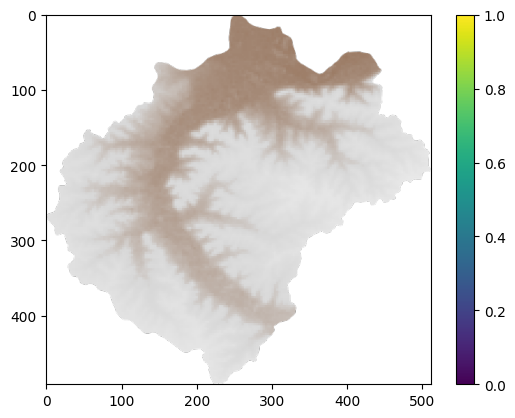

In [33]:
# Display a thumbnail of elevation map
response = requests.get(thumbnail_url )
img = plt.imread(io.BytesIO(response.content))
plt.imshow(img)
plt.colorbar()
plt.show()


## Example 4: State-level land cover

In [62]:
# Read US states
US_states = ee.FeatureCollection("TIGER/2018/States")

# Select Kansas
region = US_states.filter(ee.Filter.inList('NAME',['Kansas']))


In [79]:
# Land use
land_use = ee.ImageCollection('USDA/NASS/CDL')\
             .filter(ee.Filter.date('2020-01-01', '2021-12-31')).first().clip(region)

# Select cropland layer
cropland = land_use.select('cropland')


In [80]:
# Get layer metadata
info = land_use.getInfo()

# Remove comment to print the entire information (output is long!)
# print(info)

In [81]:
# info.keys()
# dict_keys(['type', 'bands', 'id', 'version', 'properties'])

class_names = info['properties']['cropland_class_names']
class_values = info['properties']['cropland_class_values']
class_colors = info['properties']['cropland_class_palette']


In [82]:
# Create dictionary to easily access properties by land cover name
class_props = {}
for k,name in enumerate(class_names):
    class_props[name] = {'value':class_values[k], 'color':class_colors[k]}

# Print example
class_props['Corn']


{'value': 1, 'color': 'ffd300'}

In [86]:
# Define a few land covers

corn = cropland.eq(class_props['Corn']['value']).selfMask()
sorghum = cropland.eq(class_props['Sorghum']['value']).selfMask()
soybeans = cropland.eq(class_props['Soybeans']['value']).selfMask()
wheat = cropland.eq(class_props['Winter Wheat']['value']).selfMask()
grassland = cropland.eq(class_props['Grassland/Pasture']['value']).selfMask()


In [89]:
# Create a map.
lat, lon = 37, -97
m = folium.Map(location=[lat, lon], zoom_start=6)

# Add the land cover to the map object.
create_raster(corn, {'palette':[class_props['Corn']['color']]}, 'Corn').add_to(m)
create_raster(sorghum, {'palette':[class_props['Sorghum']['color']]}, 'Sorghum').add_to(m)
create_raster(soybeans, {'palette':[class_props['Soybeans']['color']]}, 'Soybeans').add_to(m)
create_raster(wheat, {'palette':[class_props['Winter Wheat']['color']]}, 'Wheat').add_to(m)
create_raster(grassland, {'palette':[class_props['Grassland/Pasture']['color']]}, 'Grassland').add_to(m)

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)


In [93]:
# Reduce the collection and compute area of land cover
# Kansas has an area of 213,100 square kilometers
cover_value = class_props['Grassland/Pasture']['value']
cover = cropland.eq(cover_value).selfMask()

# Pass reducer as keyword arguments 
cover_count = cover.reduceRegion(**{'reducer': ee.Reducer.count(),
                                    'geometry': region.geometry(),
                                    'scale': 250})

cover_pixels = cover_count.get('cropland').getInfo()
print(cover_pixels)

1428376


In [96]:
state_area = 213_000 # km^2
state_fraction = (cover_pixels*250**2) / 10**6 / state_area 
print(state_fraction)

0.4191244131455399


## Example 5: County-level vegetation index

In [97]:
# US Counties dataset
US_counties = ee.FeatureCollection("TIGER/2018/Counties") 

# Select county of interest
county = US_counties.filter(ee.Filter.eq('GEOID','20161'))


In [98]:
# Compute median EVI for specified period
evi = ee.ImageCollection('MODIS/MCD43A4_006_EVI').filterDate('2021-04-01','2021-09-30').select('EVI')
county_evi = evi.median().clip(county)


In [99]:
# Find min and max EVI for the entire county
county_evi.reduceRegion(**{'reducer': ee.Reducer.minMax(),
                           'geometry': county.geometry(),
                           'scale': 250}).getInfo()

{'EVI_max': 0.6109167691337791, 'EVI_min': -0.0637434378008801}

In [100]:
# Set visualization parameters.
# https://colorbrewer2.org/#type=sequential&scheme=YlOrBr&n=7

palette = ['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
vis_params = {'min':0, 'max':0.55, 'palette':palette}


In [101]:
m = folium.Map(location=[39.2, -96.8], zoom_start=9)
create_raster(county_evi, vis_params, 'EVI').add_to(m)
folium.GeoJson(county.getInfo(),
               name='County boundary',
        style_function=lambda feature: {
        'fillColor': '#00FFFFFF',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }).add_to(m)
folium.LayerControl().add_to(m)
m


### Get coordinates of vector layer for selected county

In [110]:
# Get coordinates of the county geometryand put them in a dataframe for easy data handling.
df = pd.DataFrame(county.first().getInfo()['geometry']['coordinates'][0])
df.columns = ['lon','lat']
df.head()


,lon,lat
0,-96.961683,39.220095
1,-96.961369,39.220095
2,-96.956566,39.220005
3,-96.954188,39.220005
4,-96.952482,39.220005


### Save GeoTiff file to hard drive

Ensure that the size of the image fits the allowable quota. In this particular case, a 250-meter spatial resolution is enough for the entire county. This resolution may not work for larger counties or the entire state.

In [107]:
#county_evi_masked = county_evi.mask(county_evi.mask())
county_evi_masked = county_evi.mask(county_evi)

# Single-band GeoTIFF files wrapped in a zip file.
url = county_evi_masked.getDownloadUrl({
    'bands': ['EVI'],
    'region': county.geometry(),
    'scale':250,
    'format': 'GEO_TIFF'
})

# Request data using URL and save data as a new GeoTiff file
response = requests.get(url)
with open('evi_map.tif', 'wb') as f:
    f.write(response.content)

### Read saved GeoTiff file

In [108]:
# Read GeoTiff file using the Xarray package
r = xr.open_dataarray("evi_map.tif").squeeze()

# Mask array to display EVI values greater than 0 only.
r = r.where(r.values > 0)

### Create publication-quality figure

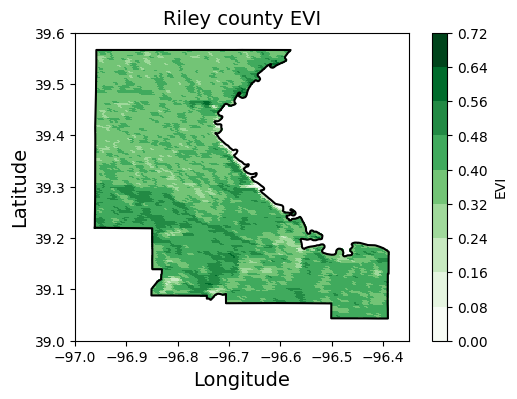

In [115]:
# Create figure

fig,ax = plt.subplots(figsize=(6,4))
r.plot(ax=ax, cmap='Greens', levels=10, cbar_kwargs={'label':'EVI'}) # Can also pass robust=True
ax.plot(df['lon'], df['lat'],'-k')
ax.set_xlabel('Longitude', size=14)
ax.set_ylabel('Latitude', size=14)
ax.set_title('Riley county EVI', size=14)
ax.set_xlim(-97,-96.35)
ax.set_ylim(39, 39.6)
ax.set_aspect('equal')
fig.savefig('riley_county_median_evi.png', dpi=300)
plt.show()


### Get Numpy array

In [116]:
# Get Numpy array
array_url = county_evi.getDownloadUrl({
    'bands': 'EVI',
    'region': county.geometry(),
    'scale':250,
    'format': 'NPY'
})

response = requests.get(array_url)
data = np.load(io.BytesIO(response.content))
print(data)
print(data.dtype)


[[(0.40681062,) (0.40681062,) (0.41871703,) ... (0.45646325,)
  (0.45646325,) (0.44876633,)]
 [(0.39371962,) (0.41703004,) (0.41703004,) ... (0.49336163,)
  (0.47600252,) (0.47600252,)]
 [(0.39371962,) (0.39371962,) (0.39371962,) ... (0.49336163,)
  (0.49336163,) (0.47600252,)]
 ...
 [(0.33285123,) (0.31952065,) (0.31952065,) ... (0.41895291,)
  (0.40293206,) (0.40293206,)]
 [(0.33285123,) (0.33285123,) (0.31952065,) ... (0.41895291,)
  (0.41895291,) (0.41895291,)]
 [(0.37987111,) (0.26453675,) (0.26453675,) ... (0.41646764,)
  (0.41646764,) (0.38346873,)]]
[('EVI', '<f8')]
